# Notebook to go step by step in the selection/reduction/calibration of DL0 data to DL1

### Some imports...

In [1]:
from ctapipe.utils import get_dataset_path
from ctapipe.io import event_source
from ctapipe.io.eventseeker import EventSeeker
import astropy.units as u

## Data loading

Get the origin file with dl0 data which is a simtelarray file

In [2]:
input_filename=get_dataset_path('gamma_test_large.simtel.gz')
#input_filename="/home/queenmab/DATA/LST1/Gamma/gamma_20deg_0deg_run8___cta-prod3-lapalma-2147m-LaPalma-FlashCam.simtel.gz"

Get the data events into a ctapipe event container. We are only interested in LST1 events

In [3]:
tel_id = 1
allowed_tels = {tel_id}
source = event_source(input_filename)
source.allowed_tels = allowed_tels

Find a bright LST event

In [4]:
intensity = 0
for event in source:
    for tid in event.r0.tels_with_data:
        if event.r0.tel[tid].image.sum() > intensity and tid in np.arange(8):
            intensity = event.r0.tel[tid].image.sum()
            bright_event = event
            tel_id = tid

Take a look at the event container. Select any event using the event seeker

In [5]:
event = bright_event

In [6]:
event.r0

ctapipe.io.containers.R0Container:
                        obs_id: observation ID
                      event_id: event id number
                tels_with_data: list of telescopes with data
                        tel[*]: map of tel_id to R0CameraContainer

In [7]:
event.r0.tel

Map(ctapipe.io.containers.R0CameraContainer,
    {1: ctapipe.io.containers.R0CameraContainer:
                       trigger_time: Telescope trigger time, start of waveform
                                     readout, None for MCs
                       trigger_type: camera's event trigger type if applicable
                       num_trig_pix: Number of trigger groups (sectors) listed
                        trig_pix_id: pixels involved in the camera trigger
                              image: numpy array containing integrated ADC data
                                     (n_channels x n_pixels) DEPRECATED
                           waveform: numpy array containing ADC samples(n_channels x
                                     n_pixels, n_samples)
                        num_samples: number of time samples for telescope,
     2: ctapipe.io.containers.R0CameraContainer:
                       trigger_time: Telescope trigger time, start of waveform
                                     

Get the waveform data

In [8]:
data = event.r0.tel[tel_id].waveform
data.shape

(2, 1855, 30)

The waveform is a matrix, has 30 samples in each of the 1855 pixels, for 2 gains. 

### We can plot the waveforms and have an idea of their shapes.

Lame loop to find a pixel with signal: 

In [9]:
maxvalue=0
for pixel in enumerate(data[0]):
    maxsample = max(pixel[1])
    if maxsample > maxvalue:
        maxvalue = maxsample
        pixelwithsignal = pixel[0]

In [10]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['font.size'] = 14
nsamples = data.shape[2]
sample = np.linspace(0,30,nsamples)
plt.plot(sample,data[0][pixelwithsignal],label="Pixel with signal",color =  "blue")
plt.plot(sample,data[0][0],label="Pixel without signal", color = "orange")
plt.legend()

## Calibration

**Get the pedestal, which is is the average (for pedestal events) of the *sum* of all samples, from sim_telarray**

In [11]:
ped = event.mc.tel[tel_id].pedestal
ped.shape

(2, 1855)

Each pixel has its pedestal for the two gains.

**Correct the pedestal (np.atleast_3d function converts 2D to 3D matrix)**

In [12]:
pedcorrectedsamples = data - np.atleast_3d(ped) / nsamples
pedcorrectedsamples.shape

(2, 1855, 30)

**We can now compare the corrected waveforms with the previous ones**

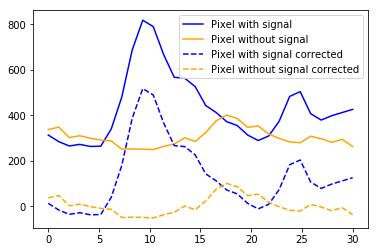

In [13]:
plt.plot(sample,data[0][pixelwithsignal],label="Pixel with signal",color="blue")
plt.plot(sample,data[0][0],label="Pixel without signal",color="orange")
plt.plot(sample,pedcorrectedsamples[0][pixelwithsignal],label="Pixel with signal corrected",color="blue",linestyle="--")
plt.plot(sample,pedcorrectedsamples[0][0],label="Pixel without signal corrected",color="orange",linestyle="--")
plt.legend()

## Integration

**We must now find the peak in the waveform and do the integration to extract the charge in the pixel**

In [14]:
from ctapipe.image.charge_extractors import LocalPeakIntegrator

In [15]:
integrator = LocalPeakIntegrator(None, None)                                                                                                        
integration, peakpos, window = integrator.extract_charge(pedcorrectedsamples)

In [16]:
integration.shape, peakpos.shape, window.shape

((2, 1855), (2, 1855), (2, 1855, 30))

Integration gives the value of the charge

In [17]:
integration[0][0],integration[0][pixelwithsignal]

(369.20004, 2244.73)

Peakpos gives the position of the peak (in which sample it falls)

In [18]:
peakpos[0][0],peakpos[0][pixelwithsignal]

(17, 9)

window gives the number of samples used for the integration

In [19]:
window[0][0],window[0][pixelwithsignal]
sample[window[0][0]]

array([14.48275862, 15.51724138, 16.55172414, 17.5862069 , 18.62068966,
       19.65517241, 20.68965517])

**We can plot these positions on top of the waveform and decide if the integration and peak identification has been correct**

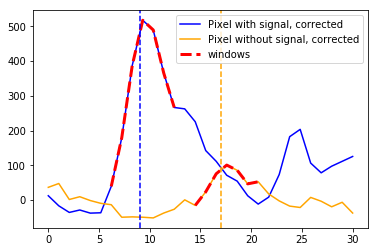

In [20]:
import matplotlib.patches as patches
plt.plot(sample,pedcorrectedsamples[0][pixelwithsignal],label="Pixel with signal, corrected",color="blue")
plt.plot(sample,pedcorrectedsamples[0][0],label="Pixel without signal, corrected",color="orange")
plt.plot(sample[window[0][0]],pedcorrectedsamples[0][0][window[0][0]],
         color="red",label="windows",linewidth=3,linestyle="--")
plt.plot(sample[window[0][pixelwithsignal]],pedcorrectedsamples[0][pixelwithsignal][window[0][pixelwithsignal]],
         color="red",linewidth=3,linestyle="--")
plt.axvline(peakpos[0][0],linestyle="--",color="orange")
plt.axvline(peakpos[0][pixelwithsignal],linestyle="--",color="blue")
plt.legend()

**Finally we must convert the charge from digital counts to photoelectrons**

In [21]:
signals = integration.astype(float)                                                                                                                 
dc2pe = event.mc.tel[tel_id].dc_to_pe  # numgains * numpixels
signals *= dc2pe

**And fill the DL1 containers**

In [22]:
event.dl1.tel[tel_id].image = signals                                                                                                         
event.dl1.tel[tel_id].peakpos = peakpos
event.dl1.tel[tel_id]

ctapipe.io.containers.DL1CameraContainer:
                         image: np array of camera image, after waveform
                                integration (N_pix)
                  gain_channel: boolean numpy array of which gain channel was
                                used for each pixel in the image
             extracted_samples: numpy array of bools indicating which samples
                                were included in the charge extraction as a
                                result of the charge extractor chosen.
                                Shape=(nchan, npix, nsamples).
                       peakpos: numpy array containing position of the peak as
                                determined by the peak-finding algorithm for
                                each pixel
                       cleaned: numpy array containing the waveform after
                                cleaning

**Say hello to our shower!**

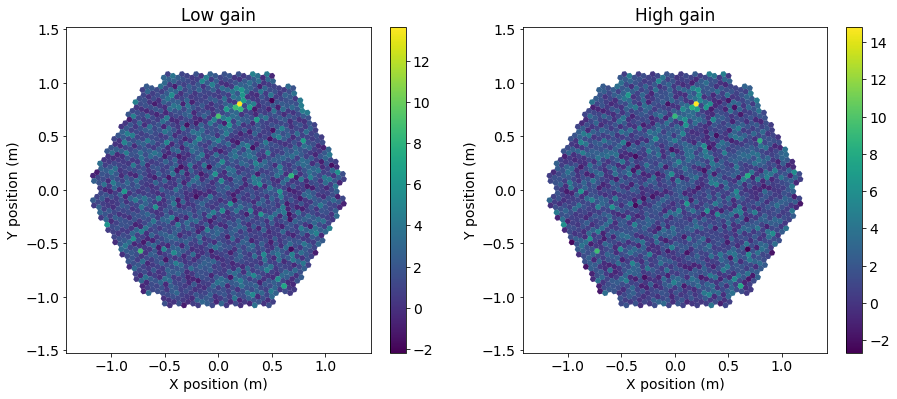

In [23]:
from ctapipe.visualization import CameraDisplay
camera = event.inst.subarray.tel[tel_id].camera
plt.rcParams['figure.figsize'] = (15, 6)
plt.rcParams['font.size'] = 14
plt.subplot(1,2,1)
disp = CameraDisplay(camera,title="Low gain")
disp.add_colorbar()
disp.image = signals[0]
plt.subplot(1,2,2)
disp = CameraDisplay(camera,title = "High gain")
disp.add_colorbar()
disp.image = signals[1]

## Image cleaning

In [24]:
from ctapipe.image import hillas_parameters, hillas_parameters_2, tailcuts_clean
cleaning_method = tailcuts_clean
cleaning_parameters = {'boundary_thresh': 0,                                                                                                            
                       'picture_thresh': 6,                                                                                                             
                       'keep_isolated_pixels': False,                                                                                                   
                       'min_number_picture_neighbors': 1                                                                                                
                       }

In [25]:
signal = signals[0]
signal_pixels = cleaning_method(camera,signal,**cleaning_parameters)

We are only using the first gain channel

In [26]:
image = signal                                                                                                                          
image[~signal_pixels] = 0

**Let's take a look at the clean and shiny image**

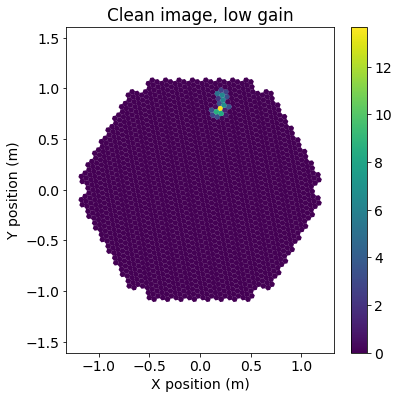

In [27]:
plt.rcParams['figure.figsize'] = (6, 6)
plt.rcParams['font.size'] = 14
disp = CameraDisplay(camera,title = "Clean image, low gain")
disp.image = image
disp.add_colorbar()

## Hillas parameters

First compute them:

In [28]:
hillas = hillas_parameters(camera, image)
hillas
hillas.intensity

84.43894782457191

**And plot them over the image**

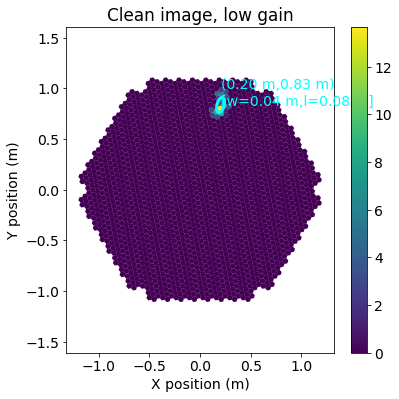

In [29]:
disp = CameraDisplay(camera,title = "Clean image, low gain")
disp.add_colorbar()
disp.image = image
disp.overlay_moments(hillas, color='cyan', linewidth=3)

**Also we can calculate the timing parameters**

In [30]:
from ctapipe.image import timing_parameters as time
timepars = time.timing_parameters(camera, image, peakpos[0], hillas)
timepars

ctapipe.io.containers.TimingParametersContainer:
                         slope: Slope of arrival times along main shower axis
                     intercept: intercept of arrival times along main shower
                                axis

In [31]:
timepars.slope,timepars.intercept

(<Quantity -5.512735 1 / m>, 12.155352405786534)

## Reconstruction of disp

In [32]:
from lstchain.reco.utils import get_event_pos_in_camera, disp, disp_to_pos

In [33]:
tel = event.inst.subarray.tel[tel_id]

In [34]:
src_pos = get_event_pos_in_camera(event, tel)

d = disp(src_pos, hillas)
s = np.sign(src_pos[0] - hillas.x)
dx = src_pos[0] - hillas.x
dy = src_pos[1] - hillas.y

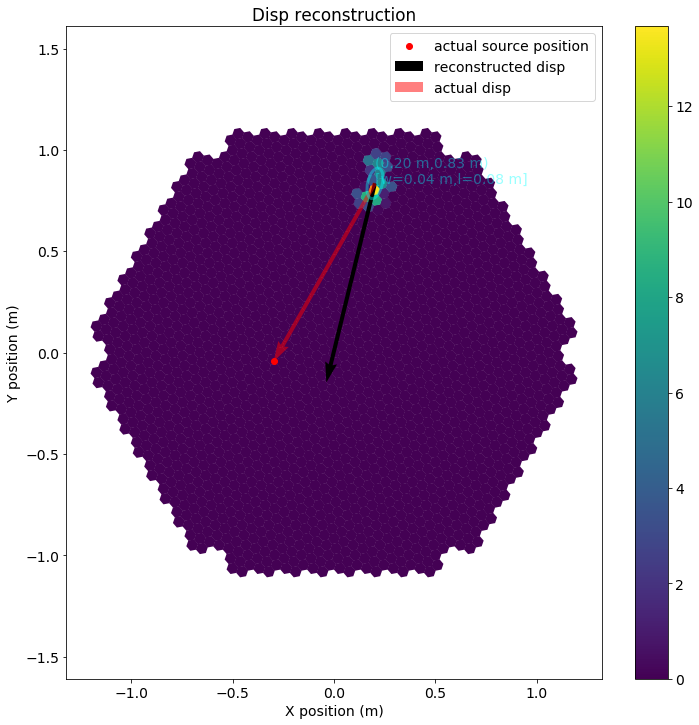

In [35]:
plt.figure(figsize=(12,12))
display = CameraDisplay(camera,title = "Disp reconstruction")
display.add_colorbar()
display.image = image
display.overlay_moments(hillas, color='cyan', linewidth=3, alpha=0.4)
plt.scatter(src_pos[0], src_pos[1], color='red', label='actual source position')
uu = s * d.value * np.cos(hillas.psi)
vv = s * d.value * np.sin(hillas.psi)
plt.quiver(hillas.x, hillas.y, uu, vv, units='xy', scale=1,
           label= "reconstructed disp",
          )

plt.quiver(hillas.x, hillas.y, dx.value, dy.value, 
           units='xy', scale=1,
           color='red',
           alpha=0.5,
           label= "actual disp", 
          )

plt.legend();

**In a real use case, the _disp_ value (length of the vector) is reconstructed by training a random forest.   
The _reconstructed disp_ above assumes a perfect length reconstruction.   
The direction of the `disp` vector is given by the ellipse direction (`hillas.psi`)**